In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

### Data input and processing

In [2]:
def standard_error(series):
    return series.std() / np.sqrt(series.count())

def process_data(new_file_path, previous_df=None):
    """
    Processes the experiment data from a new CSV file. If a previous DataFrame is provided,
    appends the new data to it; otherwise, creates a new DataFrame.

    Parameters:
    previous_df (pandas.DataFrame, optional): The existing DataFrame to append to. Defaults to None.
    new_file_path (str): The file path to the new CSV file containing the experiment data.

    Returns:
    pandas.DataFrame: A DataFrame with the combined data.
    """
    # Load the data from the new CSV file
    new_data = pd.read_csv(new_file_path)

    # Add a new column for method_name based on the value of method
    new_data['method_name'] = new_data.apply(lambda x: x['prune_method'] if x['method'] == 'prune' else x['quant_method'] if x['method'] == 'quant' else None, axis=1)
    new_data['method_name'] = new_data['method_name'].replace({'autoawq': 'AWQ', 'autogptq': 'GPTQ', 'sparsegpt': 'SparseGPT', 'wanda': 'Wanda'})

    # Selecting only relevant columns for aggregation
    aggregation_columns = ['Rewrite accuracy', 'PPL', 'Generalization', 'Latency', 'Locality']

    # Group by 'Tags' and calculate mean and standard error for the selected columns
    grouped_new_data = new_data.groupby('Tags')[aggregation_columns].agg(['mean', standard_error])

    # Flatten multi-level columns and rename them
    grouped_new_data.columns = ['_'.join(col).strip() for col in grouped_new_data.columns.values]

    # Merge the grouped new data with the extracted information
    final_new_df = pd.merge(grouped_new_data.reset_index(), new_data[['Tags', 'alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name', 'Average bits']], 
                            on='Tags', how='left').drop_duplicates()

    # Reordering columns
    final_cols = ['alg_name', 'edit', 'compress', 'sparsity_ratio', 'method_name'] + \
                 [col for col in final_new_df.columns if col not in ['alg_name', 'edit', 'compress', 'sparsity_ratio', 'Tags', 'method_name']]
    final_new_df = final_new_df[final_cols]

    # If a previous DataFrame is provided, append the new data; otherwise, use the new data as the DataFrame
    if previous_df is not None:
        combined_df = pd.concat([previous_df, final_new_df], ignore_index=True)
    else:
        combined_df = final_new_df

    return combined_df

In [29]:
## Counterfact

# No edits
unedited_counterfact = process_data('data/counterfact/none.csv')
unedited_counterfact = process_data('data/counterfact/noedit_compress.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/noedit_compress_extra.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/w4gptq_counterfact.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/w8gptq_counterfact.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/w8gptq_counterfact.csv', unedited_counterfact)
unedited_counterfact = process_data('data/counterfact/w4awq_counterfact.csv', unedited_counterfact)

# With MEMIT
edited_counterfact = process_data('data/counterfact/memit.csv')
edited_counterfact = process_data('data/counterfact/edit_compress.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/edit_compress_extra.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/w4gptq_edits_counterfact.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/w8gptq_edits_counterfact.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/w8gptq_edits_counterfact.csv', edited_counterfact)
edited_counterfact = process_data('data/counterfact/w4awq_edits_counterfact.csv', edited_counterfact)

## ZSRE

# No edits
unedited_zsre = process_data('data/zsre/none.csv')
unedited_zsre = process_data('data/zsre/noedit_compress.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/noedit_compress_extra.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/ZSRE_W4_GPTQ.csv', unedited_zsre)  # Updated file name
unedited_zsre = process_data('data/zsre/ZSRE_W8_GPTQ.csv', unedited_zsre)  # Updated file name
# The following line seems to be a duplicate of the previous one. You might want to check if this is intentional.
# unedited_zsre = process_data('data/zsre/ZSRE_W8_GPTQ.csv', unedited_zsre)
unedited_zsre = process_data('data/zsre/ZSRE_W4_AWQ.csv', unedited_zsre)  # Updated file name

# With MEMIT
edited_zsre = process_data('data/zsre/memit.csv')
edited_zsre = process_data('data/zsre/edit_compress.csv', edited_zsre)
edited_zsre = process_data('data/zsre/edit_compress_extra.csv', edited_zsre)
edited_zsre = process_data('data/zsre/ZSRE_W4_Edits_GPTQ.csv', edited_zsre)  # Updated file name
edited_zsre = process_data('data/zsre/ZSRE_W8_Edits_GPTQ.csv', edited_zsre)  # Updated file name
# The following line seems to be a duplicate of the previous one. You might want to check if this is intentional.
# edited_zsre = process_data('data/zsre/ZSRE_W8_Edits_GPTQ.csv', edited_zsre)
edited_zsre = process_data('data/zsre/ZSRE_W4_Edits_AWQ.csv', edited_zsre)  # Updated file name

## MQ

# No edits
unedited_mq = process_data('data/MQ/noedit_compress.csv')
unedited_mq = process_data('data/MQ/noedit_compress_extra.csv', unedited_mq)
unedited_mq = process_data('data/MQ/MQ_W4_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/MQ_W8_GPTQ.csv', unedited_mq)
unedited_mq = process_data('data/MQ/MQ_W4_AWQ.csv', unedited_mq)

# With MEMIT
edited_mq = process_data('data/MQ/edit_compress.csv')
edited_mq = process_data('data/MQ/edit_compress_extra.csv', edited_mq)
edited_mq = process_data('data/MQ/MQ_W4_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/MQ_W8_Edits_GPTQ.csv', edited_mq)
edited_mq = process_data('data/MQ/MQ_W4_Edits_AWQ.csv', edited_mq)



### Metrics vs avg bits

/tmp/ipykernel_801106/285777941.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_method_data = method_data.append({'Average bits': 16, metric: baseline_values[metric]}, ignore_index=True)
/tmp/ipykernel_801106/285777941.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_method_data = method_data.append({'Average bits': 16, metric: baseline_values[metric]}, ignore_index=True)
/tmp/ipykernel_801106/285777941.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  extended_method_data = method_data.append({'Average bits': 16, metric: baseline_values[metric]}, ignore_index=True)
/tmp/ipykernel_801106/285777941.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

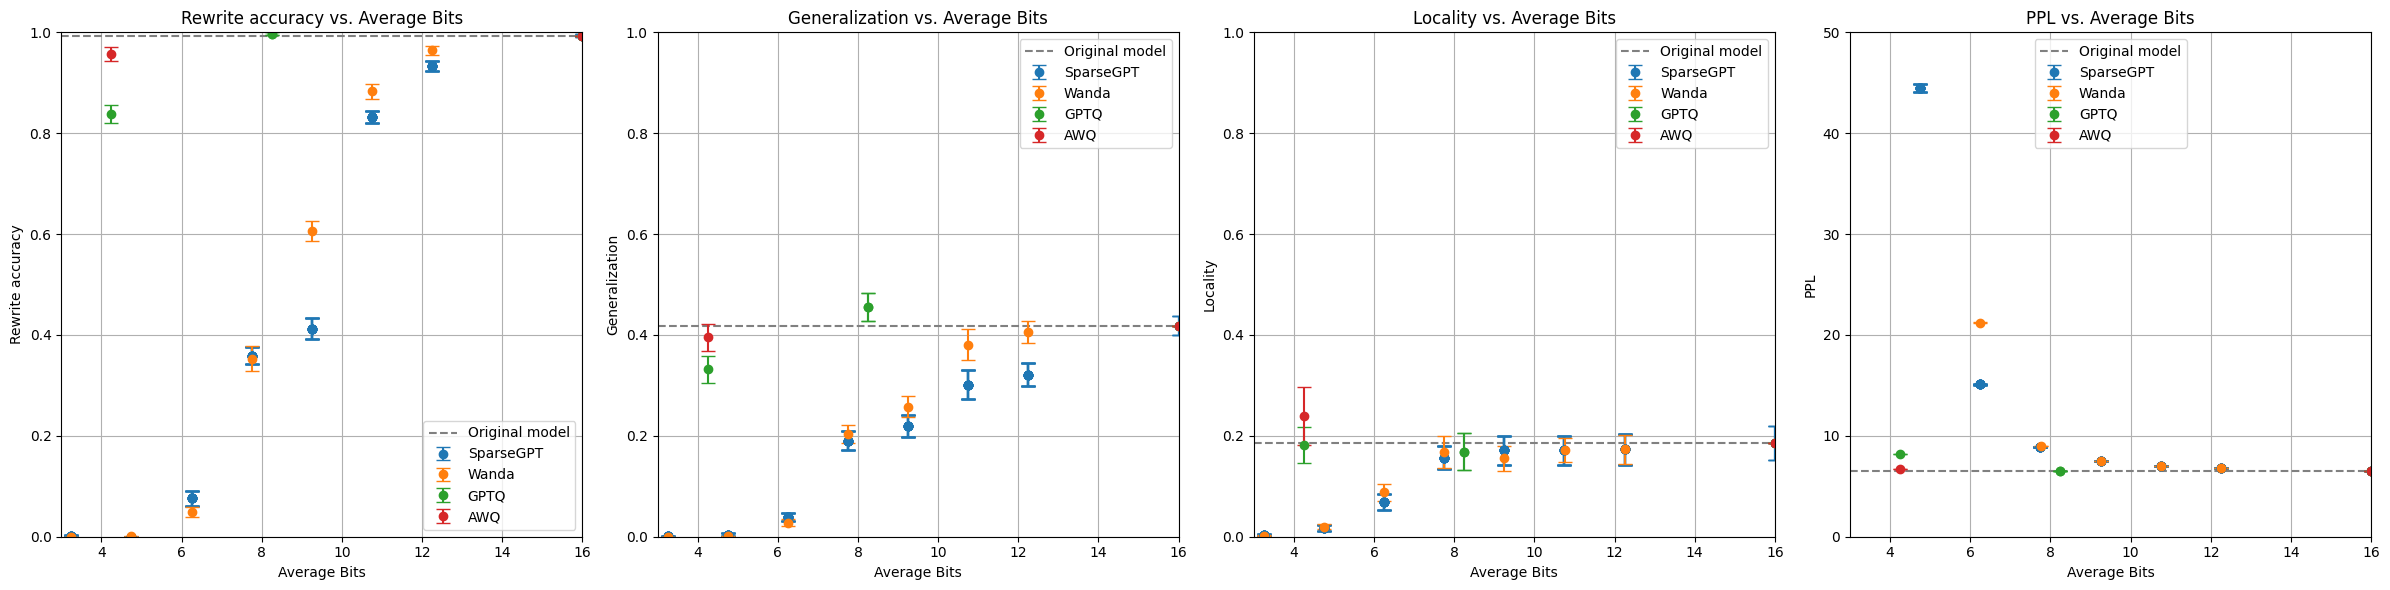

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

df = edited_counterfact

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here

metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Extract baseline values for each metric
baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}

for i, metric in enumerate(metrics):
    # Change the label 'Rewrite accuracy' to 'Success'
    ylabel = 'Success' if 'Rewrite accuracy' in metric else metric.split('_')[0]
    # Plot baseline as a horizontal dotted line
    axs[i].axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

    # Plot each method in the dataset, including a point at 16 bits for the baseline
    for method in df['method_name'].unique():
        method_data = df[df['method_name'] == method]
        # Append the baseline point at 16 bits to the method data
        extended_method_data = method_data.append({'Average bits': 16, metric: baseline_values[metric]}, ignore_index=True)
        axs[i].errorbar(extended_method_data['Average bits'], extended_method_data[metric], 
                        yerr=extended_method_data[metric.replace('mean', 'standard_error')].fillna(0), 
                        fmt='o', label=method, capsize=5)

    axs[i].set_xlabel('Average Bits')
    axs[i].set_ylabel(metric.split('_')[0])
    axs[i].set_title(f'{metric.split("_")[0]} vs. Average Bits')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlim(3, 16)

    # Set y-axis limits to 0 to 1 for the first three subplots
    if i < 3:
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(0, 50)


plt.tight_layout()
plt.show()


### Metrics vs NLL

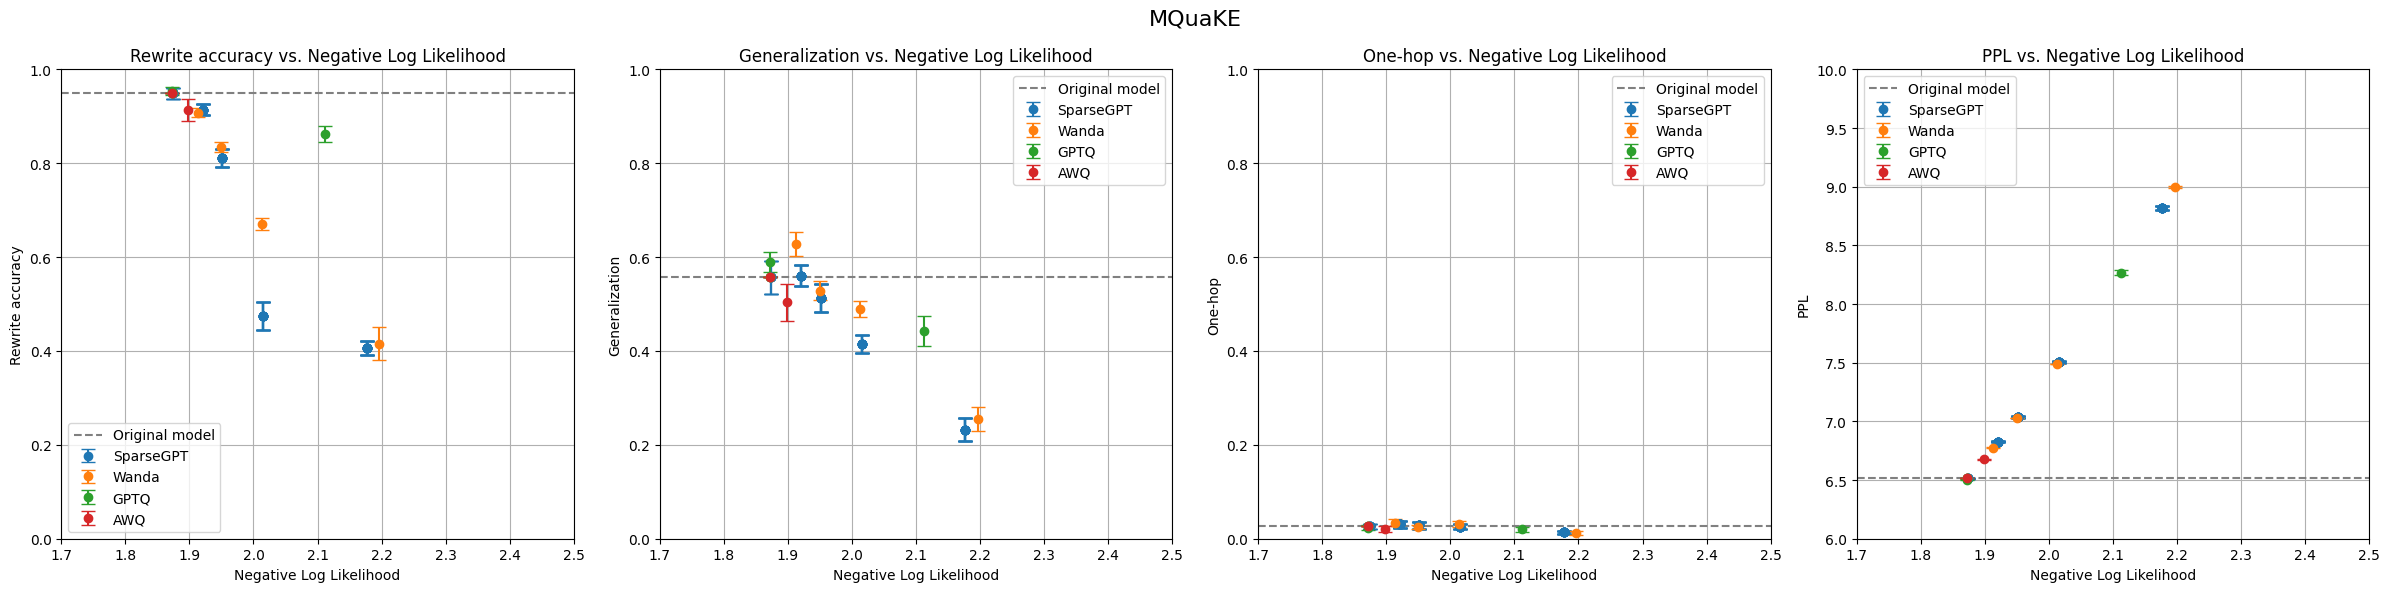

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')  # Load your DataFrame here

df = edited_mq  # Use your DataFrame

metrics = ['Rewrite accuracy_mean', 'Generalization_mean', 'Locality_mean', 'PPL_mean']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Extract baseline values for each metric
baseline_values = {metric: df[df['sparsity_ratio'] == 0][metric].mean() for metric in metrics}

# Compute NLL from PPL
df['NLL'] = np.log(df['PPL_mean'])

for i, metric in enumerate(metrics):
    # Change the label 'Rewrite accuracy' to 'Success'
    ylabel = 'Success' if 'Rewrite accuracy' in metric else metric.split('_')[0]
    ylabel = 'One-hop' if 'Locality' in metric else metric.split('_')[0]

    # Plot baseline as a horizontal dotted line
    axs[i].axhline(y=baseline_values[metric], color='gray', linestyle='--', label='Original model')

    # Plot each method in the dataset, including a baseline point at the start
    for method in df['method_name'].unique():
        method_data = df[df['method_name'] == method]
        # Prepend the baseline data point
        baseline_data = pd.DataFrame({'NLL': [df['NLL'].min()], metric: [baseline_values[metric]]})
        method_data = pd.concat([baseline_data, method_data], ignore_index=True)
        axs[i].errorbar(method_data['NLL'], method_data[metric], 
                        yerr=method_data[metric.replace('mean', 'standard_error')].fillna(0), 
                        fmt='o', label=method, capsize=5)

    axs[i].set_xlabel('Negative Log Likelihood')
    axs[i].set_ylabel(ylabel)
    axs[i].set_title(f'{ylabel} vs. Negative Log Likelihood')
    axs[i].legend()
    axs[i].grid(True)

    # Adjust y-axis limits
    if i < 3:
        axs[i].set_ylim(0, 1)
    else:
        axs[i].set_ylim(6, 10)
    axs[i].set_xlim(1.7, 2.5)
fig.suptitle('MQuaKE', fontsize=16)
plt.tight_layout()
plt.show()


### NLL comparisons

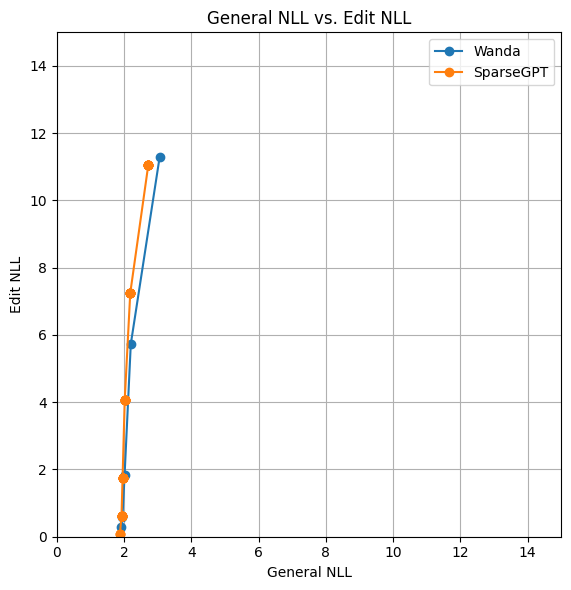

In [12]:
def create_ppl_vs_edit_ppl_plot(df):
    """
    Creates a plot for PPL vs. edit PPL from the given DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the experiment data.

    The function generates a plot:
    - PPL vs. edit PPL
    """
    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot each method, only if PPL is below 10000
    for method in df['method_name'].unique():
        method_data = df[(df['method_name'] == method) & (df['PPL edits_mean'] < np.inf)]
        ax.errorbar(np.log(method_data['PPL_mean']), np.log(method_data['PPL edits_mean']), 
                    # xerr=np.log(method_data['PPL_standard_error']), yerr=np.log(method_data['PPL_standard_error']),
                    fmt='o-', label=method, capsize=5)

    ax.set_xlabel('General NLL')
    ax.set_ylabel('Edit NLL')
    ax.set_title('General NLL vs. Edit NLL')
    ax.legend()
    ax.grid(True)

    plt.axis('square')
    # ax.set_xscale('log')
    # ax.set_yscale('log')

    ax.set_ylim(0, 15)
    ax.set_xlim(0, 15)

    plt.tight_layout()
    plt.show()

# Example usage
create_ppl_vs_edit_ppl_plot(edited_counterfact)
